Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [5]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [6]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [7]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [8]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

# Convenient functions

In [18]:
import matplotlib.pyplot as plt

In [93]:
num_steps = 4001

def run_graph(graph):
    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()
      print("Initialized")
      losses = []
      minibatchAccs = []
      validAccs = []
      
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 250 == 0):
          minibatchAccuracy = accuracy(predictions, batch_labels)
          validationAccuracy = accuracy(valid_prediction.eval(), valid_labels)

          losses.append(l)
          minibatchAccs.append(minibatchAccuracy)
          validAccs.append(validationAccuracy)

          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % minibatchAccuracy)
          print("Validation accuracy: %.1f%%" % validationAccuracy)
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
      return (losses, minibatchAccs, validAccs)

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [9]:
batch_size = 128
lreg = 0.005

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  intermediate_size = 1024 
  weights_in = tf.Variable(
    tf.truncated_normal([image_size * image_size, intermediate_size]))
  biases_in = tf.Variable(tf.zeros([intermediate_size]))
 
  weights_hidden = tf.Variable(
    tf.truncated_normal([intermediate_size, num_labels]))
  biases_hidden = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  def modelOutput(input_dataset):
    in_layer = tf.matmul(input_dataset, weights_in) + biases_in
    hidden_layer = tf.nn.relu(in_layer)
    logits = tf.matmul(hidden_layer, weights_hidden) + biases_hidden
    return logits

  logits = modelOutput(tf_train_dataset)
  loss = (tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + 
    lreg * tf.nn.l2_loss(weights_in) +
    lreg * tf.nn.l2_loss(weights_hidden) +
    lreg * tf.nn.l2_loss(biases_in) + 
    lreg * tf.nn.l2_loss(biases_hidden) 
  )
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(modelOutput(tf_valid_dataset))
  test_prediction = tf.nn.softmax(modelOutput(tf_test_dataset))

In [10]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


In [21]:
run_graph(graph)

Initialized
Minibatch loss at step 0: 366.347839
Minibatch accuracy: 16.4%
Validation accuracy: 33.6%
Minibatch loss at step 500: 18.736956
Minibatch accuracy: 79.7%
Validation accuracy: 78.2%
Minibatch loss at step 1000: 3.505894
Minibatch accuracy: 87.5%
Validation accuracy: 80.8%
Minibatch loss at step 1500: 5.216174
Minibatch accuracy: 84.4%
Validation accuracy: 80.7%
Minibatch loss at step 2000: 6.311972
Minibatch accuracy: 76.6%
Validation accuracy: 80.5%
Minibatch loss at step 2500: 4.400104
Minibatch accuracy: 78.9%
Validation accuracy: 81.3%
Minibatch loss at step 3000: 3.405824
Minibatch accuracy: 81.2%
Validation accuracy: 81.7%
Test accuracy: 88.5%


In [17]:
run_graph(graph)
## lreg = 0.001

Initialized
Minibatch loss at step 0: 656.806152
Minibatch accuracy: 14.1%
Validation accuracy: 28.5%
Minibatch loss at step 500: 195.363571
Minibatch accuracy: 84.4%
Validation accuracy: 79.4%
Minibatch loss at step 1000: 114.673264
Minibatch accuracy: 81.2%
Validation accuracy: 80.8%
Minibatch loss at step 1500: 70.176956
Minibatch accuracy: 91.4%
Validation accuracy: 82.4%
Minibatch loss at step 2000: 42.624546
Minibatch accuracy: 84.4%
Validation accuracy: 82.3%
Minibatch loss at step 2500: 25.707987
Minibatch accuracy: 85.2%
Validation accuracy: 85.2%
Minibatch loss at step 3000: 15.494772
Minibatch accuracy: 87.5%
Validation accuracy: 86.0%
Test accuracy: 92.5%


In [21]:
run_graph(graph)
## lreg = 0.01

Initialized
Minibatch loss at step 0: 3430.182373
Minibatch accuracy: 11.7%
Validation accuracy: 25.4%
Minibatch loss at step 500: 21.128643
Minibatch accuracy: 87.5%
Validation accuracy: 84.4%
Minibatch loss at step 1000: 0.729865
Minibatch accuracy: 89.1%
Validation accuracy: 82.8%
Minibatch loss at step 1500: 0.653057
Minibatch accuracy: 87.5%
Validation accuracy: 82.9%
Minibatch loss at step 2000: 0.746328
Minibatch accuracy: 83.6%
Validation accuracy: 82.8%
Minibatch loss at step 2500: 0.793419
Minibatch accuracy: 80.5%
Validation accuracy: 82.0%
Minibatch loss at step 3000: 0.707086
Minibatch accuracy: 83.6%
Validation accuracy: 82.4%
Test accuracy: 89.8%


In [23]:
run_graph(graph)
## lreg = 0.005

Initialized
Minibatch loss at step 0: 1937.234497
Minibatch accuracy: 12.5%
Validation accuracy: 37.8%
Minibatch loss at step 500: 127.339401
Minibatch accuracy: 82.8%
Validation accuracy: 81.7%
Minibatch loss at step 1000: 10.678430
Minibatch accuracy: 92.2%
Validation accuracy: 85.2%
Minibatch loss at step 1500: 1.400532
Minibatch accuracy: 90.6%
Validation accuracy: 85.0%
Minibatch loss at step 2000: 0.711106
Minibatch accuracy: 85.9%
Validation accuracy: 84.6%
Minibatch loss at step 2500: 0.710480
Minibatch accuracy: 82.8%
Validation accuracy: 84.0%
Minibatch loss at step 3000: 0.614163
Minibatch accuracy: 85.2%
Validation accuracy: 84.5%
Test accuracy: 91.0%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [43]:
batch_size = 128
lreg = 0.001

goodGraph = tf.Graph()
with goodGraph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  intermediate_size = 2048 
  weights_in = tf.Variable(
    tf.truncated_normal([image_size * image_size, intermediate_size]))
  biases_in = tf.Variable(tf.zeros([intermediate_size]))
 
  weights_hidden = tf.Variable(
    tf.truncated_normal([intermediate_size, num_labels]))
  biases_hidden = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  def modelOutput(input_dataset):
    in_layer = tf.matmul(input_dataset, weights_in) + biases_in
    hidden_layer = tf.nn.relu(in_layer)
    logits = tf.matmul(hidden_layer, weights_hidden) + biases_hidden
    return logits

  drop_outed = tf.nn.dropout(tf_train_dataset, 0.5)
  logits = modelOutput(drop_outed)

  loss = (tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + 
    lreg * tf.nn.l2_loss(weights_in) +
    lreg * tf.nn.l2_loss(weights_hidden)
  )
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(modelOutput(tf_valid_dataset))
  test_prediction = tf.nn.softmax(modelOutput(tf_test_dataset))

In [44]:
num_steps = 10000
run_graph(goodGraph)

Initialized
Minibatch loss at step 0: 1371.273682
Minibatch accuracy: 9.4%
Validation accuracy: 22.2%
Minibatch loss at step 500: 511.156769
Minibatch accuracy: 69.5%
Validation accuracy: 78.7%
Minibatch loss at step 1000: 230.352341
Minibatch accuracy: 80.5%
Validation accuracy: 78.7%
Minibatch loss at step 1500: 138.860352
Minibatch accuracy: 77.3%
Validation accuracy: 78.1%
Minibatch loss at step 2000: 79.678040
Minibatch accuracy: 75.0%
Validation accuracy: 77.9%
Minibatch loss at step 2500: 47.420040
Minibatch accuracy: 77.3%
Validation accuracy: 80.6%
Minibatch loss at step 3000: 28.467379
Minibatch accuracy: 78.9%
Validation accuracy: 82.3%
Minibatch loss at step 3500: 17.268114
Minibatch accuracy: 83.6%
Validation accuracy: 83.0%
Minibatch loss at step 4000: 10.958103
Minibatch accuracy: 75.8%
Validation accuracy: 84.0%
Minibatch loss at step 4500: 6.762144
Minibatch accuracy: 84.4%
Validation accuracy: 84.7%
Minibatch loss at step 5000: 4.442385
Minibatch accuracy: 78.9%
Valid

In [72]:
batch_size = 128
lreg = 0.005

bigGraph = tf.Graph()
with bigGraph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  intermediate_size = 1024 
  weights_in = tf.Variable(
    tf.truncated_normal([image_size * image_size, intermediate_size]))
  biases_in = tf.Variable(tf.zeros([intermediate_size]))
 
  weights_hidden1 = tf.Variable(
    tf.truncated_normal([intermediate_size, intermediate_size]))
  biases_hidden1 = tf.Variable(tf.zeros([intermediate_size]))

  weights_hidden2 = tf.Variable(
    tf.truncated_normal([intermediate_size, num_labels]))
  biases_hidden2 = tf.Variable(tf.zeros([num_labels]))
  
    
  # Training computation.
  def modelOutput(input_dataset):
    in_layer = tf.matmul(input_dataset, weights_in) + biases_in
    hidden_layer1 = tf.nn.relu(in_layer)
    hidden_layer2_in = tf.matmul(hidden_layer1, weights_hidden1) + biases_hidden1
    hidden_layer2 = tf.nn.relu(hidden_layer2_in)
    logits = tf.matmul(hidden_layer2, weights_hidden2) + biases_hidden2
    return logits

  logits = modelOutput(tf_train_dataset)

  loss = (tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + 
    lreg * tf.sqrt(tf.nn.l2_loss(weights_hidden1)) + 
    lreg * tf.sqrt(tf.nn.l2_loss(weights_hidden2))
  )
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(modelOutput(tf_valid_dataset))
  test_prediction = tf.nn.softmax(modelOutput(tf_test_dataset))

In [ ]:
run_graph(bigGraph)

In [11]:
batch_size = 128
lreg = 0.001

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  intermediate_size = 1024 
  weights_in = tf.Variable(
    tf.truncated_normal([image_size * image_size, intermediate_size]))
  biases_in = tf.Variable(tf.zeros([intermediate_size]))
 
  weights_hidden = tf.Variable(
    tf.truncated_normal([intermediate_size, num_labels]))
  biases_hidden = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  def modelOutput(input_dataset):
    in_layer = tf.matmul(input_dataset, weights_in) + biases_in
    hidden_layer = tf.nn.relu(in_layer)
    logits = tf.matmul(hidden_layer, weights_hidden) + biases_hidden
    return logits

  logits = modelOutput(tf_train_dataset)
  loss = (tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + 
    lreg * tf.nn.l2_loss(weights_in) +
    lreg * tf.nn.l2_loss(weights_hidden)
  )

  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.5, global_step, decay_steps = 250, decay_rate = 0.99) 
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step) 
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(modelOutput(tf_valid_dataset))
  test_prediction = tf.nn.softmax(modelOutput(tf_test_dataset))

In [94]:
run_graph(graph)

Initialized
Minibatch loss at step 0: 608.043518
Minibatch accuracy: 10.9%
Validation accuracy: 22.8%
Minibatch loss at step 250: 253.329636
Minibatch accuracy: 80.5%
Validation accuracy: 78.9%
Minibatch loss at step 500: 195.621262
Minibatch accuracy: 82.0%
Validation accuracy: 80.2%
Minibatch loss at step 750: 150.492783
Minibatch accuracy: 84.4%
Validation accuracy: 81.1%
Minibatch loss at step 1000: 116.203957
Minibatch accuracy: 79.7%
Validation accuracy: 81.1%
Minibatch loss at step 1250: 92.088135
Minibatch accuracy: 80.5%
Validation accuracy: 82.0%
Minibatch loss at step 1500: 72.220261
Minibatch accuracy: 89.1%
Validation accuracy: 82.6%
Minibatch loss at step 1750: 56.348274
Minibatch accuracy: 84.4%
Validation accuracy: 84.0%
Minibatch loss at step 2000: 44.605263
Minibatch accuracy: 89.8%
Validation accuracy: 84.5%
Minibatch loss at step 2250: 35.805111
Minibatch accuracy: 78.1%
Validation accuracy: 85.2%
Minibatch loss at step 2500: 28.487425
Minibatch accuracy: 87.5%
Vali

([608.04352,
  253.32964,
  195.62126,
  150.49278,
  116.20396,
  92.088135,
  72.220261,
  56.348274,
  44.605263,
  35.805111,
  28.487425,
  22.629585,
  18.291178,
  14.916031,
  11.89362,
  9.8473883,
  8.1035805],
 [10.9375,
  80.46875,
  82.03125,
  84.375,
  79.6875,
  80.46875,
  89.0625,
  84.375,
  89.84375,
  78.125,
  87.5,
  90.625,
  89.0625,
  85.15625,
  90.625,
  85.9375,
  84.375],
 [22.82,
  78.92,
  80.16,
  81.1,
  81.08,
  82.05,
  82.64,
  83.99,
  84.51,
  85.17,
  85.83,
  86.08,
  86.38,
  86.83,
  87.45,
  87.41,
  87.66])

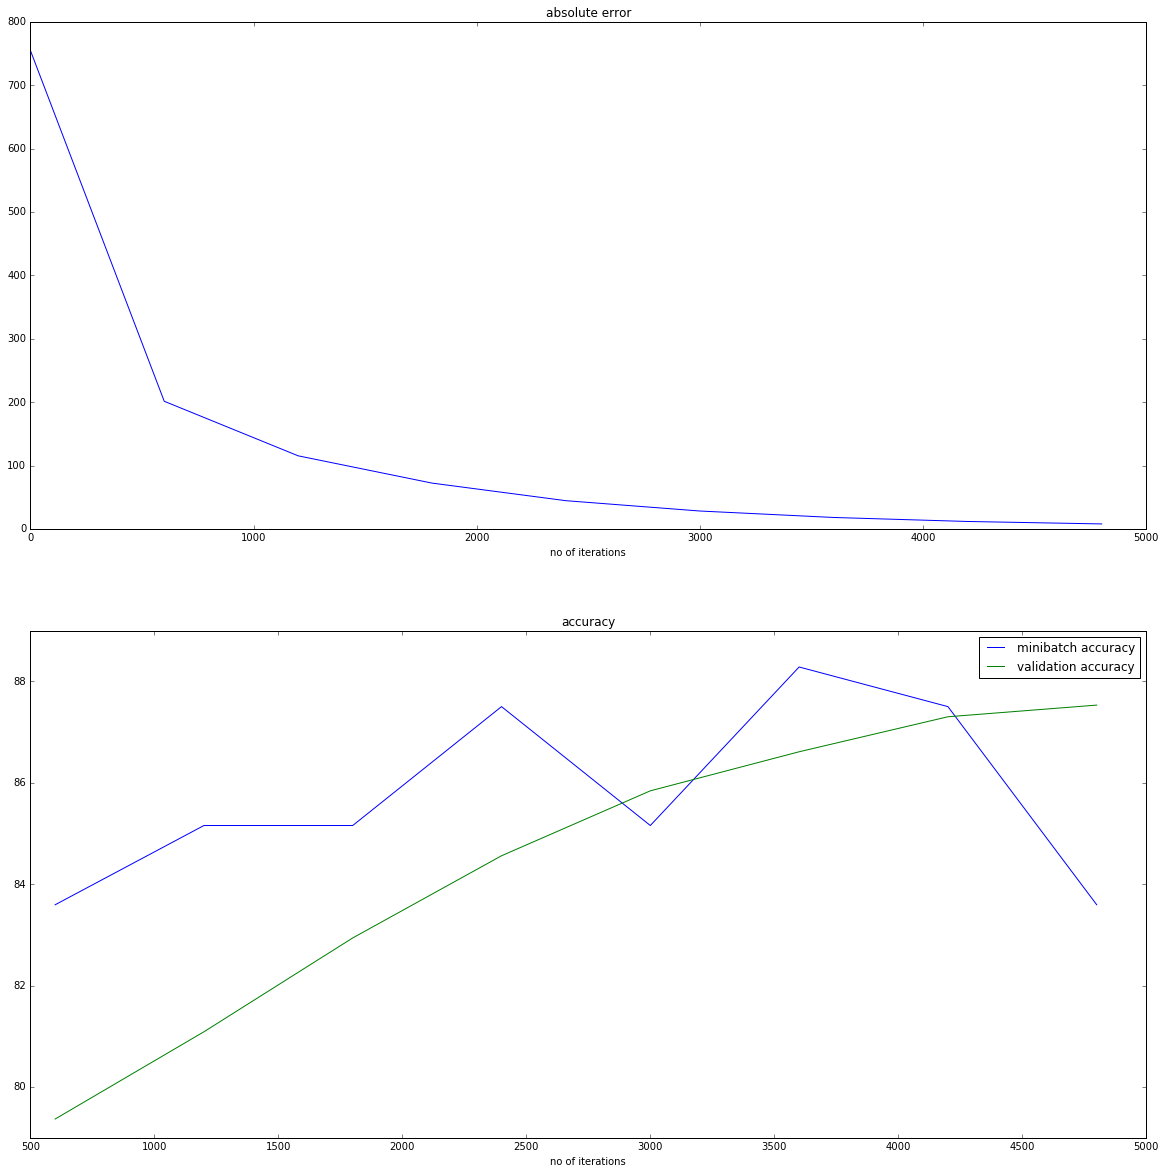

In [95]:
%matplotlib inline

no_interpolated = (num_steps / 500) + 1 
steps = map(lambda x: x * 600, range(0, no_interpolated))

f1 = plt.figure()
f1.set_figheight(40)
f1.set_figwidth(40)
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.title("absolute error")
plt.plot(steps, stats[0])
plt.xlabel("no of iterations")

plt.subplot(212)
plt.title("accuracy")
plt.plot(steps[1:], stats[1][1:], label = "minibatch accuracy")
plt.xlabel("no of iterations")
plt.plot(steps[1::], stats[2][1:], label = "validation accuracy")
plt.legend()